In [1]:
%run center_of_mass_calculation.ipynb

In [2]:
%run 3phase_pm_engine_simulation.ipynb

In [3]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from tensorflow.keras import backend as K

In [4]:
df = pd.read_csv("full_df.csv", header=None)

In [5]:
data = df.to_numpy()

In [6]:
X = data[:, :29]
y = data[:, 29:] * 100

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=137)

In [8]:
X_train = tf.constant(X_train, dtype="float32")
X_test = tf.constant(X_test, dtype="float32")
y_train = tf.constant(y_train, dtype="float32")
y_test = tf.constant(y_test, dtype="float32")

In [9]:
X_train.shape

TensorShape([41783, 29])

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100_000).batch(256)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1000)

In [11]:
def hundred_relu(x):
    return K.relu(x, max_value=100)

In [12]:
class EvaluatorNetwork(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden_layers = [
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
        ]
        self.output_layer = tf.keras.layers.Dense(1, activation=hundred_relu)
        
    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

In [20]:
evaluator = EvaluatorNetwork()

In [21]:
evaluator.build(input_shape=(None, 29))
evaluator.summary()

Model: "evaluator_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  multiple                 116       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             multiple                  1920      
                                                                 
 dense_5 (Dense)             multiple                  4160      
                                                                 
 dense_6 (Dense)             multiple                  4160      
                                                                 
 dense_7 (Dense)             multiple                  65        
                                                                 
Total params: 10,421
Trainable params: 10,363
Non-trainable params: 58
__________________________________________

In [22]:
loss_object = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001)

In [23]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [24]:
@tf.function
def evaluator_train_step(params, perf):
    with tf.GradientTape() as tape:
        predictions = evaluator(params, training=True)
        loss = loss_object(perf, predictions)
    gradients = tape.gradient(loss, evaluator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, evaluator.trainable_variables))

    train_loss(loss)


In [25]:
@tf.function
def evaluator_test_step(params, perf):
    predictions = evaluator(params, training=False)
    t_loss = loss_object(perf, predictions)

    test_loss(t_loss)


In [26]:
EPOCHS = 500

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    i = 0
    for params, perf in train_ds:
        evaluator_train_step(params, perf)

    for params, perf in test_ds:
        evaluator_test_step(params, perf)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Test Loss: {test_loss.result()}, '
    )


Epoch 1, Loss: 48.87505340576172, Test Loss: 41.092647552490234, 
Epoch 2, Loss: 29.679698944091797, Test Loss: 10.80240535736084, 
Epoch 3, Loss: 8.67816162109375, Test Loss: 7.029417991638184, 
Epoch 4, Loss: 6.384271621704102, Test Loss: 5.968738079071045, 
Epoch 5, Loss: 5.7814130783081055, Test Loss: 5.644043922424316, 
Epoch 6, Loss: 5.554055690765381, Test Loss: 5.46052885055542, 
Epoch 7, Loss: 5.395282745361328, Test Loss: 5.315282344818115, 
Epoch 8, Loss: 5.242210388183594, Test Loss: 5.188177585601807, 
Epoch 9, Loss: 5.117482662200928, Test Loss: 5.070277214050293, 
Epoch 10, Loss: 5.0027642250061035, Test Loss: 4.964953899383545, 
Epoch 11, Loss: 4.881549835205078, Test Loss: 4.868453025817871, 
Epoch 12, Loss: 4.801510334014893, Test Loss: 4.777055263519287, 
Epoch 13, Loss: 4.702637195587158, Test Loss: 4.691908359527588, 
Epoch 14, Loss: 4.6196699142456055, Test Loss: 4.613702297210693, 
Epoch 15, Loss: 4.538541316986084, Test Loss: 4.543344974517822, 
Epoch 16, Loss: 

KeyboardInterrupt: 

In [27]:
evaluator(tf.reshape(canonical_parameters, shape=(1, 29)))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[50.345535]], dtype=float32)>

In [28]:
canonical_parameters = tf.constant(
    [25.276] * 17 + [16] * 12,
    dtype="float32"
)
canonical_parameters = tf.reshape(canonical_parameters, shape=(1, 29))

In [29]:
trans_mult = tf.constant([45] * 17 + [8] * 12, dtype="float32")
trans_add = tf.constant([5] * 17 + [16] * 12, dtype="float32")

In [30]:
class OptimizerNetwork(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
        ]
        self.output_layer = tf.keras.layers.Dense(29, activation="sigmoid")
        
    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        x *= trans_mult
        x += trans_add
        return x

In [40]:
optimizer = OptimizerNetwork()

In [41]:
optimizer.build(input_shape=(None, 29))
optimizer.summary()

Model: "optimizer_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            multiple                  3840      
                                                                 
 dense_14 (Dense)            multiple                  16512     
                                                                 
 dense_15 (Dense)            multiple                  8256      
                                                                 
 dense_16 (Dense)            multiple                  2080      
                                                                 
 dense_17 (Dense)            multiple                  957       
                                                                 
Total params: 31,645
Trainable params: 31,645
Non-trainable params: 0
_________________________________________________________________


In [42]:
loss_object = tf.keras.losses.MeanAbsoluteError()
nadam = tf.keras.optimizers.Nadam(learning_rate=0.0001)

In [43]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [44]:
@tf.function
def optimizer_train_step(params):
    with tf.GradientTape() as tape:
        predictions = optimizer(params, training=True)
        evaluation = evaluator(predictions, training=False) / 100
        loss = 1 - evaluation
    gradients = tape.gradient(loss, optimizer.trainable_variables)
    nadam.apply_gradients(zip(gradients, optimizer.trainable_variables))

    train_loss(loss)
    return predictions

In [45]:
EPOCHS = 200
possible_densities = tf.random.uniform((1, 17), minval=5, maxval=50, dtype="float32", seed=42)
params = tf.random.uniform((1, 12), minval=16, maxval=24, dtype="float32", seed=42)
params = tf.concat([possible_densities, params], axis=1)

params = tf.reshape(params, shape=(1, 29))

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    params = optimizer_train_step(params)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
    )

Epoch 1, Loss: 0.4614155888557434, 
Epoch 2, Loss: 0.44052553176879883, 
Epoch 3, Loss: 0.43913179636001587, 
Epoch 4, Loss: 0.4166135787963867, 
Epoch 5, Loss: 0.44802194833755493, 
Epoch 6, Loss: 0.43418699502944946, 
Epoch 7, Loss: 0.43008875846862793, 
Epoch 8, Loss: 0.40896403789520264, 
Epoch 9, Loss: 0.4048801064491272, 
Epoch 10, Loss: 0.389570415019989, 
Epoch 11, Loss: 0.38671815395355225, 
Epoch 12, Loss: 0.3837262988090515, 
Epoch 13, Loss: 0.3738945722579956, 
Epoch 14, Loss: 0.3822762370109558, 
Epoch 15, Loss: 0.37402069568634033, 
Epoch 16, Loss: 0.37375110387802124, 
Epoch 17, Loss: 0.37267357110977173, 
Epoch 18, Loss: 0.3584631681442261, 
Epoch 19, Loss: 0.36900949478149414, 
Epoch 20, Loss: 0.3628655672073364, 
Epoch 21, Loss: 0.3595730662345886, 
Epoch 22, Loss: 0.36103934049606323, 
Epoch 23, Loss: 0.3448185324668884, 
Epoch 24, Loss: 0.35086071491241455, 
Epoch 25, Loss: 0.3470314145088196, 
Epoch 26, Loss: 0.34472817182540894, 
Epoch 27, Loss: 0.3455911874771118

In [47]:
params

<tf.Tensor: shape=(1, 29), dtype=float32, numpy=
array([[49.999996 , 49.99993  ,  6.0733767,  5.057633 ,  5.0000215,
         5.0015955,  5.1109986,  5.136513 ,  5.0182495,  5.057583 ,
         5.551576 ,  5.332079 ,  5.012101 ,  5.053944 , 49.99966  ,
         5.018517 , 49.999924 , 16.004532 , 23.99833  , 23.999153 ,
        23.159641 , 16.000074 , 23.874561 , 24.       , 16.029768 ,
        16.027681 , 16.055325 , 23.999912 , 23.999594 ]], dtype=float32)>

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.01566267],
        [0.06093216]], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.9720097>)

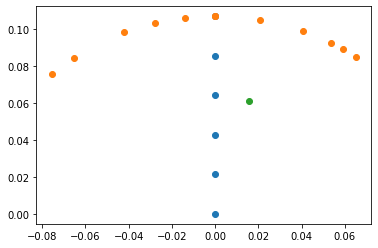

In [48]:
calculate_center_of_mass(tf.reshape(params, (29,)), show_plots=True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.76106596>

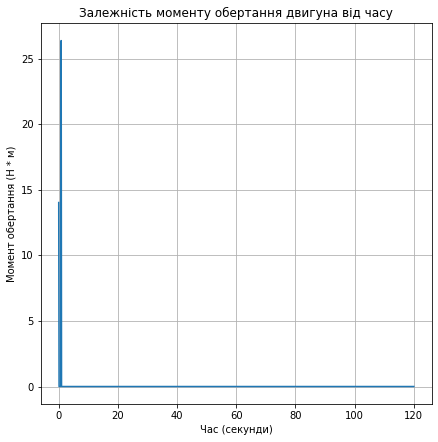

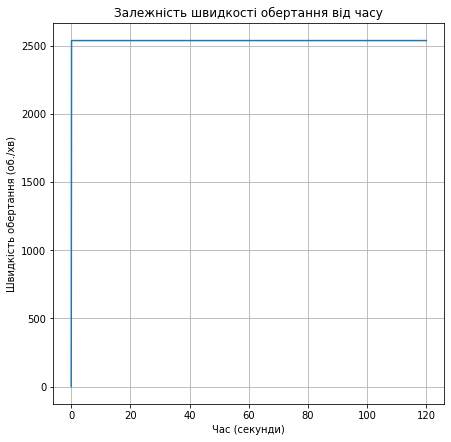

In [49]:
t = np.linspace(0, 120, 1000)
evaluate_efficiency(tf.reshape(params, (29,)), t, show_plots=True)

In [50]:
evaluate_efficiency(tf.reshape(canonical_parameters, (29,)), t)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5056526>

In [52]:
d = tf.concat([tf.reshape(params, (29,)), tf.constant([0.76106596])], axis=0).numpy()
d = tf.reshape(d, shape=(30, 1))
bdf = pd.DataFrame(d)
bdf.to_csv("best_params.csv", index=False, header=False)